In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
import torch.utils.data as data
from torchvision import transforms
import torchvision

In [2]:
from torchinfo import summary

In [3]:

import sys,os
sys.path.append(os.pardir)

import py_func.Deep_learning_torch_func as DL
import py_func.models_func as my_model
import py_func.dat_rb_func as drb
import py_func.my_numpy_class as mnc
import py_func.my_torch_class as mtc
import py_func.models_func as my_model

import py_func.Deep_learning_torch_func as DL
import py_func.dat_rb_func as drb

from torch.optim import lr_scheduler
import numpy as np
import importlib
import os.path as osp


import matplotlib.pyplot as plt

In [6]:
importlib.reload(mtc)

<module 'py_func.my_torch_class' from '../py_func/my_torch_class.py'>

## FashionMNIST experiment dataset 68000train shuffle

In [28]:
outputdir = "../output/experiment/SLM_phase/fm"
howdatadir = osp.join(outputdir, "id/midline_randomshuffle_68000train/")

datapath = '../dat/experiment/SLM/fm_6_18/fm_1_70000_slt0.4_0.8_N3_lsd_midline.dat'
labelpath='../dat/label/fm_label.dat'

shfldir= "../output/experiment/SLM_phase"
shflidpath=osp.join(shfldir, "shuffle_first_68000.npy")
trainid = np.load(file=shflidpath)
shflidpath=osp.join(shfldir, "shuffle_68001_69000.npy")
valid = np.load(file=shflidpath)
shflidpath=osp.join(shfldir, "shuffle_69001_70000.npy")
testid = np.load(file=shflidpath)

In [29]:
fm = mnc.My_numpy(1, datapath)
fm.simread(70000, 1600)
print(fm.data.shape)

fm.data = fm.data.reshape(70000, 1, 1600)
print(fm.data.shape)

fmlbl = mnc.My_numpy(4, labelpath)
fmlbl.labelread(70000)
print(fmlbl.data.shape)


myset = mtc.My_dataset2(fm.data, fmlbl.data)
myset.numpy2tensor_labelint()
traindata, trainlabel = myset.index_splitdata(trainid)
valdata, vallabel = myset.index_splitdata(valid)
testdata, testlabel = myset.index_splitdata(testid)

myset.set3data(traindata, val=valdata, test=testdata)
myset.set3label(trainlabel, val=vallabel, test=testlabel)

myset.datanormalize()
myset.tensor2dataset()

batch=256
mlt = DataLoader(myset.dataset_train, batch_size = batch, shuffle = True)
mlv = DataLoader(myset.dataset_val, batch_size = batch, shuffle = False)
mltest = DataLoader(myset.dataset_test, batch_size = batch, shuffle = False)

print(len(mlt), len(mlv), len(mltest))

(70000, 1600)
(70000, 1, 1600)
(70000,)
266 4 4


In [34]:
channel = [1, 16]
kernel_size = [128]
pool_list = [3]
criterion = nn.NLLLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = my_model.cnn1d(channel, kernel_size, pool_list, 10, 0.5, 128).to(device)

In [35]:
summary(model = model, input_size = (1,1,1600), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
cnn1d                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 491]              --
│    └─Conv1d_Bn_ReLU_Pool: 2-1          [1, 16, 491]              --
│    │    └─Sequential: 3-1              [1, 16, 491]              --
│    │    │    └─Conv1d: 4-1             [1, 16, 1473]             2,064
│    │    │    └─BatchNorm1d: 4-2        [1, 16, 1473]             32
│    │    │    └─ReLU: 4-3               [1, 16, 1473]             --
│    │    │    └─MaxPool1d: 4-4          [1, 16, 491]              --
├─Flatten: 1-2                           [1, 7856]                 --
├─Dropout: 1-3                           [1, 7856]                 --
├─Linear: 1-4                            [1, 128]                  1,005,696
├─ReLU: 1-5                              [1, 128]                  --
├─Dropout: 1-6                           [1, 128]                  --
├─Lin

----------------------------epoch1------------------------------
train_loss0.0089 ,train_acc0.1585, val_loss0.0091 ,val_acc0.1460
epochtime:0.0386 minutes
----------------------------epoch2------------------------------
train_loss0.0085 ,train_acc0.3215, val_loss0.0087 ,val_acc0.3040
epochtime:0.0352 minutes
----------------------------epoch3------------------------------
train_loss0.0081 ,train_acc0.3661, val_loss0.0083 ,val_acc0.3570
epochtime:0.0344 minutes
----------------------------epoch4------------------------------
train_loss0.0077 ,train_acc0.4072, val_loss0.0079 ,val_acc0.4070
epochtime:0.0339 minutes
----------------------------epoch5------------------------------
train_loss0.0074 ,train_acc0.4330, val_loss0.0076 ,val_acc0.4410
epochtime:0.0353 minutes
----------------------------epoch6------------------------------
train_loss0.0071 ,train_acc0.4604, val_loss0.0073 ,val_acc0.4600
epochtime:0.0356 minutes
----------------------------epoch7------------------------------
train

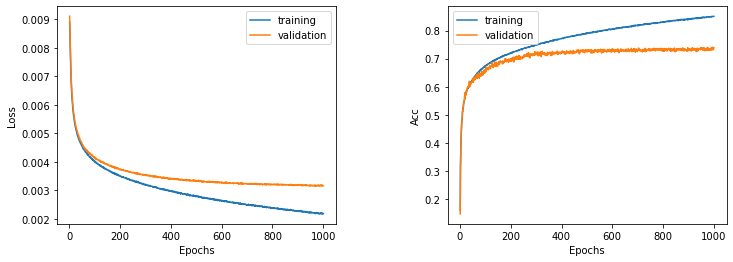

[0.709, 0.003437964975833893]


In [36]:
optimizer = optim.Adam(model.parameters(), lr=1e-05)

epochs = 1000

# lrdir=osp.join(howdatadir, "1e-05")
# modelsavedir = osp.join(lrdir, "16ch128ks3pool")
#md_path = osp.join(modelsavedir, 'last.pth')

#training
tl, vl, ta, va = DL.train_model_ver3(mlt, mlv, model, criterion, optimizer, epochs, device, 
                                    mean_or_improve="improve", decision_num=10,)

#torch.save(model.state_dict(), md_path)
DL.learning_curv_ver2( 12, 4, 10, 10, tls = tl, vls = vl, tas = ta, vas = va)


val = DL.val_model(mltest, model, device, criterion, False)
print(val)

#### notpool notdrop model  16ch 128ks 12M そんなに変わらない

In [6]:
channel = [1, 16]
kernel_size = [128]
criterion = nn.NLLLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = my_model.cnn1d_notpool_notdrop(channel, kernel_size, 10, 128).to(device)

/home/kawamoto/anaconda3/envs/mytorch373/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
summary(model = model, input_size = (1,1,1600), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
cnn1d_notpool_notdrop                    [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 1473]             --
│    └─Conv1d_Bn_ReLU: 2-1               [1, 16, 1473]             --
│    │    └─Sequential: 3-1              [1, 16, 1473]             --
│    │    │    └─Conv1d: 4-1             [1, 16, 1473]             2,064
│    │    │    └─BatchNorm1d: 4-2        [1, 16, 1473]             32
│    │    │    └─ReLU: 4-3               [1, 16, 1473]             --
├─Flatten: 1-2                           [1, 23568]                --
├─Linear: 1-3                            [1, 128]                  3,016,832
├─ReLU: 1-4                              [1, 128]                  --
├─Linear: 1-5                            [1, 10]                   1,290
Total params: 3,020,218
Trainable params: 3,020,218
Non-trainable params: 0
Total mult-adds (M): 6.06
Input size (MB): 0.01
Forward/backward p

In [8]:
lrdir=osp.join(howdatadir, "1e-05")
optimizer = optim.Adam(model.parameters(), lr=1e-05)

epochs = 1000

# modelsavedir = osp.join(lrdir, "8ch128ks")
# md_path = osp.join(modelsavedir, 'm68000_1600_expe_e1000.pth')

#training
tl, vl, ta, va = DL.train_model_ver3(mlt, mlv, model, criterion, optimizer, epochs, device)

# torch.save(model.state_dict(), md_path)
DL.learning_curv_ver2( 12, 4, 10, 10, tls = tl, vls = vl, tas = ta, vas = va)


val = DL.val_model(mltest, model, device, criterion, False)
print(val)

----------------------------epoch1------------------------------
val_acc0.4880 ,train_acc0.4808
epochtime:0.0396 minutes
----------------------------epoch2------------------------------
val_acc0.5560 ,train_acc0.5379
epochtime:0.0350 minutes
----------------------------epoch3------------------------------
val_acc0.5770 ,train_acc0.5694
epochtime:0.0351 minutes
----------------------------epoch4------------------------------
val_acc0.5920 ,train_acc0.5926
epochtime:0.0354 minutes
----------------------------epoch5------------------------------
val_acc0.6140 ,train_acc0.6100
epochtime:0.0341 minutes
----------------------------epoch6------------------------------
val_acc0.6140 ,train_acc0.6189
epochtime:0.0358 minutes
----------------------------epoch7------------------------------
val_acc0.6360 ,train_acc0.6324
epochtime:0.0349 minutes
----------------------------epoch8------------------------------
val_acc0.6470 ,train_acc0.6442
epochtime:0.0340 minutes
----------------------------epoc

KeyboardInterrupt: 

#### lr1e-05 8ch128ks 3M notsave 71.5%

In [35]:
channel = [1, 8]
kernel_size = [128]
pool_list = [2]
criterion = nn.NLLLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = my_model.cnn1d(channel, kernel_size, pool_list, 10, 0.5, 128).to(device)

In [36]:
summary(model = model, input_size = (1,1,1600), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
cnn1d                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 736]               --
│    └─Conv1d_Bn_ReLU_Pool: 2-1          [1, 8, 736]               --
│    │    └─Sequential: 3-1              [1, 8, 736]               --
│    │    │    └─Conv1d: 4-1             [1, 8, 1473]              1,032
│    │    │    └─BatchNorm1d: 4-2        [1, 8, 1473]              16
│    │    │    └─ReLU: 4-3               [1, 8, 1473]              --
│    │    │    └─MaxPool1d: 4-4          [1, 8, 736]               --
├─Flatten: 1-2                           [1, 5888]                 --
├─Dropout: 1-3                           [1, 5888]                 --
├─Linear: 1-4                            [1, 128]                  753,792
├─ReLU: 1-5                              [1, 128]                  --
├─Dropout: 1-6                           [1, 128]                  --
├─Linea

----------------------------epoch1------------------------------
val_acc0.1690 ,train_acc0.1746
epochtime:0.1719 minutes
----------------------------epoch2------------------------------
val_acc0.2610 ,train_acc0.2760
epochtime:0.1710 minutes
----------------------------epoch3------------------------------
val_acc0.3260 ,train_acc0.3375
epochtime:0.2021 minutes
----------------------------epoch4------------------------------
val_acc0.3670 ,train_acc0.3880
epochtime:0.1567 minutes
----------------------------epoch5------------------------------
val_acc0.3820 ,train_acc0.4129
epochtime:0.2144 minutes
----------------------------epoch6------------------------------
val_acc0.4180 ,train_acc0.4390
epochtime:0.1725 minutes
----------------------------epoch7------------------------------
val_acc0.4220 ,train_acc0.4606
epochtime:0.1692 minutes
----------------------------epoch8------------------------------
val_acc0.4380 ,train_acc0.4704
epochtime:0.2011 minutes
----------------------------epoc

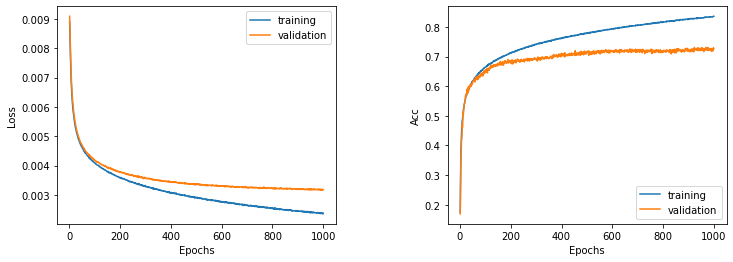

[0.715, 0.0035540683269500734]


In [37]:
lrdir=osp.join(howdatadir, "1e-05")
optimizer = optim.Adam(model.parameters(), lr=1e-05)

epochs = 1000

# modelsavedir = osp.join(lrdir, "8ch128ks")
# md_path = osp.join(modelsavedir, 'm68000_1600_expe_e1000.pth')

#training
tl, vl, ta, va = DL.train_model_ver3(mlt, mlv, model, criterion, optimizer, epochs, device)

# torch.save(model.state_dict(), md_path)
DL.learning_curv_ver2( 12, 4, 10, 10, tls = tl, vls = vl, tas = ta, vas = va)


val = DL.val_model(mltest, model, device, criterion, False)
print(val)

#### lr1e-05 epoch 1000 32ch512ks 8.98M 73.7%

In [38]:
channel = [1, 32]
kernel_size = [512]
pool_list = [2]
criterion = nn.NLLLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = my_model.cnn1d(channel, kernel_size, pool_list, 10, 0.5, 128).to(device)

In [39]:
summary(model = model, input_size = (1,1,1600), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
cnn1d                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 544]              --
│    └─Conv1d_Bn_ReLU_Pool: 2-1          [1, 32, 544]              --
│    │    └─Sequential: 3-1              [1, 32, 544]              --
│    │    │    └─Conv1d: 4-1             [1, 32, 1089]             16,416
│    │    │    └─BatchNorm1d: 4-2        [1, 32, 1089]             64
│    │    │    └─ReLU: 4-3               [1, 32, 1089]             --
│    │    │    └─MaxPool1d: 4-4          [1, 32, 544]              --
├─Flatten: 1-2                           [1, 17408]                --
├─Dropout: 1-3                           [1, 17408]                --
├─Linear: 1-4                            [1, 128]                  2,228,352
├─ReLU: 1-5                              [1, 128]                  --
├─Dropout: 1-6                           [1, 128]                  --
├─Li

----------------------------epoch1------------------------------
val_acc0.2880 ,train_acc0.3098
epochtime:0.0522 minutes
----------------------------epoch2------------------------------
val_acc0.3990 ,train_acc0.4109
epochtime:0.0516 minutes
----------------------------epoch3------------------------------
val_acc0.4500 ,train_acc0.4598
epochtime:0.0512 minutes
----------------------------epoch4------------------------------
val_acc0.4800 ,train_acc0.4829
epochtime:0.0517 minutes
----------------------------epoch5------------------------------
val_acc0.4990 ,train_acc0.5008
epochtime:0.0511 minutes
----------------------------epoch6------------------------------
val_acc0.4970 ,train_acc0.5212
epochtime:0.0521 minutes
----------------------------epoch7------------------------------
val_acc0.5360 ,train_acc0.5359
epochtime:0.0516 minutes
----------------------------epoch8------------------------------
val_acc0.5360 ,train_acc0.5390
epochtime:0.0510 minutes
----------------------------epoc

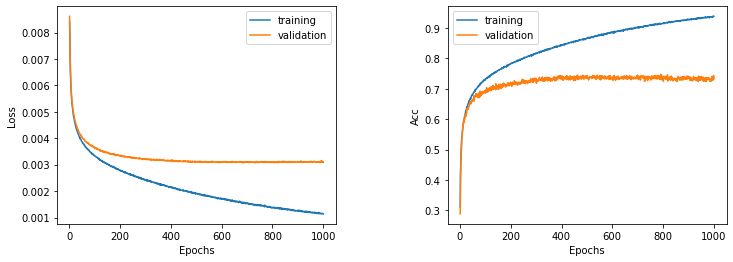

[0.737, 0.0033803551197052]


In [40]:
lrdir=osp.join(howdatadir, "1e-05")
optimizer = optim.Adam(model.parameters(), lr=1e-05)

epochs = 1000

# modelsavedir = osp.join(lrdir, "32ch512ks")
# md_path = osp.join(modelsavedir, 'm68000_1600_expe_e1000.pth')

#training
tl, vl, ta, va = DL.train_model_ver3(mlt, mlv, model, criterion, optimizer, epochs, device)

# torch.save(model.state_dict(), md_path)
DL.learning_curv_ver2( 12, 4, 10, 10, tls = tl, vls = vl, tas = ta, vas = va)


val = DL.val_model(mltest, model, device, criterion, False)
print(val)

#### lr1e-05 epoch1000 16ch256ks 5.5M 72.6%

In [41]:
channel = [1, 16]
kernel_size = [256]
pool_list = [2]
criterion = nn.NLLLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = my_model.cnn1d(channel, kernel_size, pool_list, 10, 0.5, 128).to(device)

In [42]:
summary(model = model, input_size = (1,1,1600), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
cnn1d                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 672]              --
│    └─Conv1d_Bn_ReLU_Pool: 2-1          [1, 16, 672]              --
│    │    └─Sequential: 3-1              [1, 16, 672]              --
│    │    │    └─Conv1d: 4-1             [1, 16, 1345]             4,112
│    │    │    └─BatchNorm1d: 4-2        [1, 16, 1345]             32
│    │    │    └─ReLU: 4-3               [1, 16, 1345]             --
│    │    │    └─MaxPool1d: 4-4          [1, 16, 672]              --
├─Flatten: 1-2                           [1, 10752]                --
├─Dropout: 1-3                           [1, 10752]                --
├─Linear: 1-4                            [1, 128]                  1,376,384
├─ReLU: 1-5                              [1, 128]                  --
├─Dropout: 1-6                           [1, 128]                  --
├─Lin

----------------------------epoch1------------------------------
val_acc0.2550 ,train_acc0.2778
epochtime:0.0369 minutes
----------------------------epoch2------------------------------
val_acc0.3510 ,train_acc0.3748
epochtime:0.0371 minutes
----------------------------epoch3------------------------------
val_acc0.4140 ,train_acc0.4280
epochtime:0.0359 minutes
----------------------------epoch4------------------------------
val_acc0.4340 ,train_acc0.4575
epochtime:0.0371 minutes
----------------------------epoch5------------------------------
val_acc0.4640 ,train_acc0.4770
epochtime:0.0371 minutes
----------------------------epoch6------------------------------
val_acc0.4870 ,train_acc0.4957
epochtime:0.0358 minutes
----------------------------epoch7------------------------------
val_acc0.5190 ,train_acc0.5087
epochtime:0.0368 minutes
----------------------------epoch8------------------------------
val_acc0.5300 ,train_acc0.5214
epochtime:0.0357 minutes
----------------------------epoc

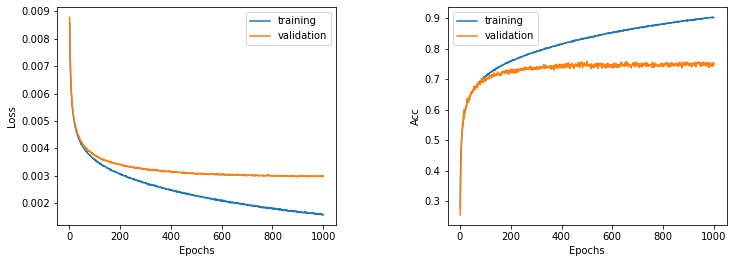

[0.726, 0.003349629580974579]


In [43]:
lrdir=osp.join(howdatadir, "1e-05")
optimizer = optim.Adam(model.parameters(), lr=1e-05)

epochs = 1000

# modelsavedir = osp.join(lrdir, "16ch256ks")
# md_path = osp.join(modelsavedir, 'm68000_1600_expe_e1000.pth')

#training
tl, vl, ta, va = DL.train_model_ver3(mlt, mlv, model, criterion, optimizer, epochs, device)

# torch.save(model.state_dict(), md_path)
DL.learning_curv_ver2( 12, 4, 10, 10, tls = tl, vls = vl, tas = ta, vas = va)


val = DL.val_model(mltest, model, device, criterion, False)
print(val)

#### lr1e-05 epoch1000 16ch128ks param6M 73.1%

In [24]:
channel = [1, 16]
kernel_size = [128]
pool_list = [2]
criterion = nn.NLLLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = my_model.cnn1d(channel, kernel_size, pool_list, 10, 0.5, 128).to(device)

/home/kawamoto/anaconda3/envs/mytorch373/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [25]:
summary(model = model, input_size = (1,1,1600), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
cnn1d                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 736]              --
│    └─Conv1d_Bn_ReLU_Pool: 2-1          [1, 16, 736]              --
│    │    └─Sequential: 3-1              [1, 16, 736]              --
│    │    │    └─Conv1d: 4-1             [1, 16, 1473]             2,064
│    │    │    └─BatchNorm1d: 4-2        [1, 16, 1473]             32
│    │    │    └─ReLU: 4-3               [1, 16, 1473]             --
│    │    │    └─MaxPool1d: 4-4          [1, 16, 736]              --
├─Flatten: 1-2                           [1, 11776]                --
├─Dropout: 1-3                           [1, 11776]                --
├─Linear: 1-4                            [1, 128]                  1,507,456
├─ReLU: 1-5                              [1, 128]                  --
├─Dropout: 1-6                           [1, 128]                  --
├─Lin

----------------------------epoch1------------------------------
val_acc0.2490 ,train_acc0.2654
epochtime:0.0727 minutes
----------------------------epoch2------------------------------
val_acc0.3600 ,train_acc0.3854
epochtime:0.0337 minutes
----------------------------epoch3------------------------------
val_acc0.4420 ,train_acc0.4381
epochtime:0.0349 minutes
----------------------------epoch4------------------------------
val_acc0.4890 ,train_acc0.4808
epochtime:0.0350 minutes
----------------------------epoch5------------------------------
val_acc0.5090 ,train_acc0.5008
epochtime:0.0339 minutes
----------------------------epoch6------------------------------
val_acc0.5230 ,train_acc0.5125
epochtime:0.0349 minutes
----------------------------epoch7------------------------------
val_acc0.5460 ,train_acc0.5250
epochtime:0.0348 minutes
----------------------------epoch8------------------------------
val_acc0.5450 ,train_acc0.5345
epochtime:0.0345 minutes
----------------------------epoc

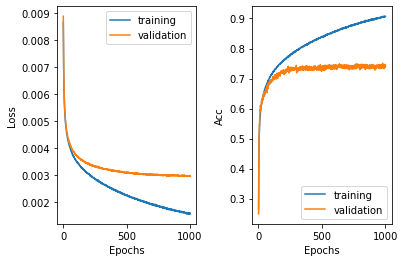

[0.731, 0.003254784941673279]


In [8]:
lrdir=osp.join(howdatadir, "1e-05")
optimizer = optim.Adam(model.parameters(), lr=1e-05)

epochs = 1000

modelsavedir = osp.join(lrdir, "16ch128ks")
md_path = osp.join(modelsavedir, 'm68000_1600_expe_e1000.pth')

#training
tl, vl, ta, va = DL.train_model_ver3(mlt, mlv, model, criterion, optimizer, epochs, device
, modelsavedir=modelsavedir, saveepoch=100, saveinterval=50)

torch.save(model.state_dict(), md_path)
DL.learning_curv_ver2( 12, 4, 10, 10, tls = tl, vls = vl, tas = ta, vas = va)


val = DL.val_model(mltest, model, device, criterion, False)
print(val)

/home/kawamoto/anaconda3/envs/mytorch373/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### lr1e-05 epoch1000 16ch64ks 72.7%

In [ ]:
channel = [1, 16]
kernel_size = [64]
pool_list = [2]
criterion = nn.NLLLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = my_model.cnn1d(channel, kernel_size, pool_list, 10, 0.5, 128).to(device)

----------------------------epoch1------------------------------
val_acc0.2680 ,train_acc0.2590
epochtime:0.0335 minutes
----------------------------epoch2------------------------------
val_acc0.3630 ,train_acc0.3796
epochtime:0.0326 minutes
----------------------------epoch3------------------------------
val_acc0.4180 ,train_acc0.4421
epochtime:0.0322 minutes
----------------------------epoch4------------------------------
val_acc0.4720 ,train_acc0.4754
epochtime:0.0327 minutes
----------------------------epoch5------------------------------
val_acc0.4960 ,train_acc0.4980
epochtime:0.0334 minutes
----------------------------epoch6------------------------------
val_acc0.5130 ,train_acc0.5136
epochtime:0.0323 minutes
----------------------------epoch7------------------------------
val_acc0.5310 ,train_acc0.5282
epochtime:0.0330 minutes
----------------------------epoch8------------------------------
val_acc0.5470 ,train_acc0.5447
epochtime:0.0331 minutes
----------------------------epoc

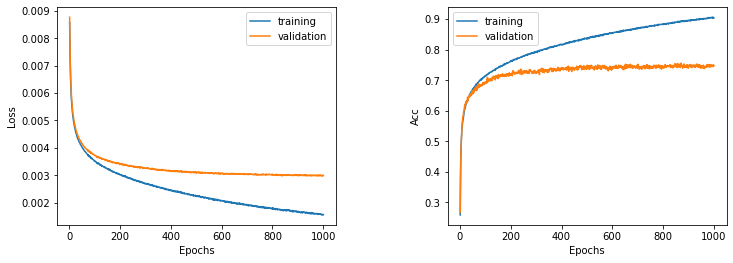

[0.727, 0.0033189512491226198]


In [10]:
lrdir=osp.join(howdatadir, "1e-05")
optimizer = optim.Adam(model.parameters(), lr=1e-05)

epochs = 1000

modelsavedir = osp.join(lrdir, "16ch64ks")
md_path = osp.join(modelsavedir, 'm68000_1600_expe_e1000.pth')

#training
tl, vl, ta, va = DL.train_model_ver3(mlt, mlv, model, criterion, optimizer, epochs, device
, modelsavedir=modelsavedir, saveepoch=100, saveinterval=50)

torch.save(model.state_dict(), md_path)
DL.learning_curv_ver2( 12, 4, 10, 10, tls = tl, vls = vl, tas = ta, vas = va)


val = DL.val_model(mltest, model, device, criterion, False)
print(val)

## FashionMNIST simulation dataset 68000train not shuffle

In [5]:
outputdir = "../output/sim/SLM_phase/fm"
howdatadir = osp.join(outputdir, "id/68000train/")

datapath = '../dat/simdat/SLM_phase/1byte/lsd/fm/fm_4cm_4cm_3.3mm_notpad_4096x2400_samevalue_sclup_to8192x4800_sim.dat'
labelpath='../dat/label/fm_label.dat'

In [6]:
fm=mnc.My_numpy(1, datapath)
fm.simread(70000, 4096)
fm.data=fm.data.reshape(70000, 1, 4096)
print(fm.data.shape)

(70000, 1, 4096)


In [7]:
data=fm.data[:,:,int(4096/2)-int(1600/2):int(4096/2)+int(1600/2)]
print(data.shape)

(70000, 1, 1600)


In [8]:
fmlbl=mnc.My_numpy(4, labelpath)
fmlbl.labelread(70000)
print(fmlbl.data.shape)

(70000,)


In [9]:
myset=mtc.My_dataset2(data, fmlbl.data)
myset.numpy2tensor_labelint()
trainset, valset, testset=myset.splitdata(68000, 1000, 1000)
myset.set3data(trainset[0], valset[0], testset[0])
myset.set3label(trainset[1], valset[1], testset[1])

myset.datanormalize()
myset.tensor2dataset()
batch=256
flt=DataLoader(myset.dataset_train, batch_size=batch, shuffle=True)
flv=DataLoader(myset.dataset_val, batch_size=batch, shuffle=False)
fltest=DataLoader(myset.dataset_test, batch_size=batch, shuffle=False)

print(len(flt), len(flv), len(fltest))

266 4 4


#### simulation 16ch128ks 1e-05

In [4]:
channel = [1, 16]
kernel_size = [128]
pool_list = [2]
criterion = nn.NLLLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = my_model.cnn1d(channel, kernel_size, pool_list, 10, 0.5, 128).to(device)

/home/kawamoto/anaconda3/envs/mytorch373/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
summary(model = model, input_size = (1,1,1600), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
cnn1d                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 736]              --
│    └─Conv1d_Bn_ReLU_Pool: 2-1          [1, 16, 736]              --
│    │    └─Sequential: 3-1              [1, 16, 736]              --
│    │    │    └─Conv1d: 4-1             [1, 16, 1473]             2,064
│    │    │    └─BatchNorm1d: 4-2        [1, 16, 1473]             32
│    │    │    └─ReLU: 4-3               [1, 16, 1473]             --
│    │    │    └─MaxPool1d: 4-4          [1, 16, 736]              --
├─Flatten: 1-2                           [1, 11776]                --
├─Dropout: 1-3                           [1, 11776]                --
├─Linear: 1-4                            [1, 128]                  1,507,456
├─ReLU: 1-5                              [1, 128]                  --
├─Dropout: 1-6                           [1, 128]                  --
├─Lin

In [11]:
device

device(type='cuda', index=0)

In [12]:
lrdir=osp.join(howdatadir, "lr1e-05")

----------------------------epoch1------------------------------
val_acc0.6390 ,train_acc0.6288
epochtime:0.0929 minutes
----------------------------epoch2------------------------------
val_acc0.6840 ,train_acc0.6807
epochtime:0.0366 minutes
----------------------------epoch3------------------------------
val_acc0.7110 ,train_acc0.7098
epochtime:0.0372 minutes
----------------------------epoch4------------------------------
val_acc0.7330 ,train_acc0.7255
epochtime:0.0374 minutes
----------------------------epoch5------------------------------
val_acc0.7470 ,train_acc0.7394
epochtime:0.0365 minutes
----------------------------epoch6------------------------------
val_acc0.7540 ,train_acc0.7478
epochtime:0.0366 minutes
----------------------------epoch7------------------------------
val_acc0.7620 ,train_acc0.7558
epochtime:0.0372 minutes
----------------------------epoch8------------------------------
val_acc0.7690 ,train_acc0.7622
epochtime:0.0357 minutes
----------------------------epoc

----------------------------epoch69------------------------------
val_acc0.8230 ,train_acc0.8495
epochtime:0.0367 minutes
----------------------------epoch70------------------------------
val_acc0.8200 ,train_acc0.8496
epochtime:0.0355 minutes
----------------------------epoch71------------------------------
val_acc0.8250 ,train_acc0.8500
epochtime:0.0360 minutes
----------------------------epoch72------------------------------
val_acc0.8240 ,train_acc0.8510
epochtime:0.0354 minutes
----------------------------epoch73------------------------------
val_acc0.8260 ,train_acc0.8523
epochtime:0.0365 minutes
----------------------------epoch74------------------------------
val_acc0.8220 ,train_acc0.8534
epochtime:0.0359 minutes
----------------------------epoch75------------------------------
val_acc0.8280 ,train_acc0.8540
epochtime:0.0388 minutes
----------------------------epoch76------------------------------
val_acc0.8320 ,train_acc0.8546
epochtime:0.0420 minutes
------------------------

----------------------------epoch136------------------------------
val_acc0.8250 ,train_acc0.8836
epochtime:0.0359 minutes
----------------------------epoch137------------------------------
val_acc0.8260 ,train_acc0.8834
epochtime:0.0353 minutes
----------------------------epoch138------------------------------
val_acc0.8290 ,train_acc0.8844
epochtime:0.0361 minutes
----------------------------epoch139------------------------------
val_acc0.8290 ,train_acc0.8849
epochtime:0.0360 minutes
----------------------------epoch140------------------------------
val_acc0.8250 ,train_acc0.8837
epochtime:0.0353 minutes
----------------------------epoch141------------------------------
val_acc0.8270 ,train_acc0.8861
epochtime:0.0361 minutes
----------------------------epoch142------------------------------
val_acc0.8230 ,train_acc0.8851
epochtime:0.0359 minutes
----------------------------epoch143------------------------------
val_acc0.8250 ,train_acc0.8862
epochtime:0.0354 minutes
----------------

----------------------------epoch203------------------------------
val_acc0.8350 ,train_acc0.9088
epochtime:0.0364 minutes
----------------------------epoch204------------------------------
val_acc0.8330 ,train_acc0.9098
epochtime:0.0356 minutes
----------------------------epoch205------------------------------
val_acc0.8360 ,train_acc0.9096
epochtime:0.0364 minutes
----------------------------epoch206------------------------------
val_acc0.8340 ,train_acc0.9107
epochtime:0.0362 minutes
----------------------------epoch207------------------------------
val_acc0.8380 ,train_acc0.9115
epochtime:0.0353 minutes
----------------------------epoch208------------------------------
val_acc0.8350 ,train_acc0.9102
epochtime:0.0360 minutes
----------------------------epoch209------------------------------
val_acc0.8350 ,train_acc0.9111
epochtime:0.0362 minutes
----------------------------epoch210------------------------------
val_acc0.8380 ,train_acc0.9109
epochtime:0.0354 minutes
----------------

----------------------------epoch270------------------------------
val_acc0.8380 ,train_acc0.9287
epochtime:0.0361 minutes
----------------------------epoch271------------------------------
val_acc0.8370 ,train_acc0.9299
epochtime:0.0361 minutes
----------------------------epoch272------------------------------
val_acc0.8400 ,train_acc0.9298
epochtime:0.0353 minutes
----------------------------epoch273------------------------------
val_acc0.8450 ,train_acc0.9312
epochtime:0.0360 minutes
----------------------------epoch274------------------------------
val_acc0.8390 ,train_acc0.9298
epochtime:0.0360 minutes
----------------------------epoch275------------------------------
val_acc0.8390 ,train_acc0.9301
epochtime:0.0354 minutes
----------------------------epoch276------------------------------
val_acc0.8450 ,train_acc0.9314
epochtime:0.0360 minutes
----------------------------epoch277------------------------------
val_acc0.8440 ,train_acc0.9316
epochtime:0.0354 minutes
----------------

----------------------------epoch337------------------------------
val_acc0.8400 ,train_acc0.9468
epochtime:0.0373 minutes
----------------------------epoch338------------------------------
val_acc0.8390 ,train_acc0.9468
epochtime:0.0371 minutes
----------------------------epoch339------------------------------
val_acc0.8430 ,train_acc0.9476
epochtime:0.0355 minutes
----------------------------epoch340------------------------------
val_acc0.8400 ,train_acc0.9479
epochtime:0.0365 minutes
----------------------------epoch341------------------------------
val_acc0.8370 ,train_acc0.9475
epochtime:0.0359 minutes
----------------------------epoch342------------------------------
val_acc0.8410 ,train_acc0.9483
epochtime:0.0353 minutes
----------------------------epoch343------------------------------
val_acc0.8430 ,train_acc0.9482
epochtime:0.0359 minutes
----------------------------epoch344------------------------------
val_acc0.8370 ,train_acc0.9488
epochtime:0.0359 minutes
----------------

----------------------------epoch404------------------------------
val_acc0.8430 ,train_acc0.9597
epochtime:0.0358 minutes
----------------------------epoch405------------------------------
val_acc0.8440 ,train_acc0.9603
epochtime:0.0361 minutes
----------------------------epoch406------------------------------
val_acc0.8410 ,train_acc0.9591
epochtime:0.0361 minutes
----------------------------epoch407------------------------------
val_acc0.8450 ,train_acc0.9617
epochtime:0.0352 minutes
----------------------------epoch408------------------------------
val_acc0.8430 ,train_acc0.9605
epochtime:0.0358 minutes
----------------------------epoch409------------------------------
val_acc0.8490 ,train_acc0.9611
epochtime:0.0359 minutes
----------------------------epoch410------------------------------
val_acc0.8430 ,train_acc0.9611
epochtime:0.0353 minutes
----------------------------epoch411------------------------------
val_acc0.8410 ,train_acc0.9605
epochtime:0.0359 minutes
----------------

----------------------------epoch471------------------------------
val_acc0.8430 ,train_acc0.9701
epochtime:0.0355 minutes
----------------------------epoch472------------------------------
val_acc0.8420 ,train_acc0.9710
epochtime:0.0376 minutes
----------------------------epoch473------------------------------
val_acc0.8410 ,train_acc0.9700
epochtime:0.0407 minutes
----------------------------epoch474------------------------------
val_acc0.8400 ,train_acc0.9711
epochtime:0.0400 minutes
----------------------------epoch475------------------------------
val_acc0.8410 ,train_acc0.9695
epochtime:0.0389 minutes
----------------------------epoch476------------------------------
val_acc0.8400 ,train_acc0.9715
epochtime:0.0374 minutes
----------------------------epoch477------------------------------
val_acc0.8430 ,train_acc0.9704
epochtime:0.0402 minutes
----------------------------epoch478------------------------------
val_acc0.8400 ,train_acc0.9704
epochtime:0.0404 minutes
----------------

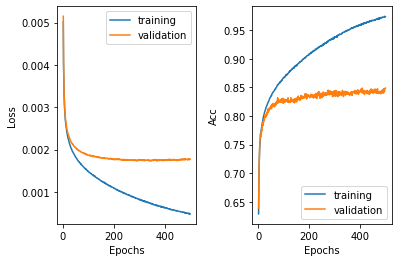

[0.84, 0.0018175404071807861]


In [14]:
optimizer = optim.Adam(model.parameters(), lr=1e-05)

epochs = 500

# modelsavedir = osp.join(lrdir, "16ch128ks")
# md_path = osp.join(modelsavedir, 'm30000_1600_expe_e1000.pth')

#training
tl, vl, ta, va = DL.train_model_ver3(flt, flv, model, criterion, optimizer, epochs, device)

#torch.save(model.state_dict(), md_path)
DL.learning_curv_ver2( 12, 4, 10, 10, tls = tl, vls = vl, tas = ta, vas = va)


val = DL.val_model(fltest, model, device, criterion, False)
print(val)

#### same lr=5e-06

----------------------------epoch1------------------------------
val_acc0.5680 ,train_acc0.5473
epochtime:0.0420 minutes
----------------------------epoch2------------------------------
val_acc0.6290 ,train_acc0.6251
epochtime:0.0423 minutes
----------------------------epoch3------------------------------
val_acc0.6650 ,train_acc0.6573
epochtime:0.0414 minutes
----------------------------epoch4------------------------------
val_acc0.6820 ,train_acc0.6798
epochtime:0.0422 minutes
----------------------------epoch5------------------------------
val_acc0.6950 ,train_acc0.6974
epochtime:0.0418 minutes
----------------------------epoch6------------------------------
val_acc0.7100 ,train_acc0.7091
epochtime:0.0425 minutes
----------------------------epoch7------------------------------
val_acc0.7230 ,train_acc0.7184
epochtime:0.0424 minutes
----------------------------epoch8------------------------------
val_acc0.7310 ,train_acc0.7276
epochtime:0.0416 minutes
----------------------------epoc

----------------------------epoch69------------------------------
val_acc0.8060 ,train_acc0.8215
epochtime:0.0427 minutes
----------------------------epoch70------------------------------
val_acc0.8020 ,train_acc0.8216
epochtime:0.0424 minutes
----------------------------epoch71------------------------------
val_acc0.8070 ,train_acc0.8230
epochtime:0.0415 minutes
----------------------------epoch72------------------------------
val_acc0.8060 ,train_acc0.8232
epochtime:0.0403 minutes
----------------------------epoch73------------------------------
val_acc0.8060 ,train_acc0.8229
epochtime:0.0409 minutes
----------------------------epoch74------------------------------
val_acc0.8090 ,train_acc0.8233
epochtime:0.0406 minutes
----------------------------epoch75------------------------------
val_acc0.8130 ,train_acc0.8247
epochtime:0.0409 minutes
----------------------------epoch76------------------------------
val_acc0.8060 ,train_acc0.8250
epochtime:0.0408 minutes
------------------------

----------------------------epoch136------------------------------
val_acc0.8210 ,train_acc0.8492
epochtime:0.0367 minutes
----------------------------epoch137------------------------------
val_acc0.8220 ,train_acc0.8497
epochtime:0.0357 minutes
----------------------------epoch138------------------------------
val_acc0.8210 ,train_acc0.8503
epochtime:0.0364 minutes
----------------------------epoch139------------------------------
val_acc0.8170 ,train_acc0.8502
epochtime:0.0367 minutes
----------------------------epoch140------------------------------
val_acc0.8180 ,train_acc0.8508
epochtime:0.0365 minutes
----------------------------epoch141------------------------------
val_acc0.8220 ,train_acc0.8516
epochtime:0.0368 minutes
----------------------------epoch142------------------------------
val_acc0.8200 ,train_acc0.8509
epochtime:0.0364 minutes
----------------------------epoch143------------------------------
val_acc0.8200 ,train_acc0.8513
epochtime:0.0368 minutes
----------------

----------------------------epoch203------------------------------
val_acc0.8250 ,train_acc0.8691
epochtime:0.0352 minutes
----------------------------epoch204------------------------------
val_acc0.8280 ,train_acc0.8699
epochtime:0.0357 minutes
----------------------------epoch205------------------------------
val_acc0.8200 ,train_acc0.8700
epochtime:0.0352 minutes
----------------------------epoch206------------------------------
val_acc0.8210 ,train_acc0.8697
epochtime:0.0358 minutes
----------------------------epoch207------------------------------
val_acc0.8220 ,train_acc0.8703
epochtime:0.0358 minutes
----------------------------epoch208------------------------------
val_acc0.8230 ,train_acc0.8710
epochtime:0.0352 minutes
----------------------------epoch209------------------------------
val_acc0.8250 ,train_acc0.8709
epochtime:0.0358 minutes
----------------------------epoch210------------------------------
val_acc0.8220 ,train_acc0.8710
epochtime:0.0359 minutes
----------------

----------------------------epoch270------------------------------
val_acc0.8340 ,train_acc0.8846
epochtime:0.0359 minutes
----------------------------epoch271------------------------------
val_acc0.8310 ,train_acc0.8857
epochtime:0.0353 minutes
----------------------------epoch272------------------------------
val_acc0.8340 ,train_acc0.8855
epochtime:0.0358 minutes
----------------------------epoch273------------------------------
val_acc0.8300 ,train_acc0.8859
epochtime:0.0358 minutes
----------------------------epoch274------------------------------
val_acc0.8290 ,train_acc0.8861
epochtime:0.0353 minutes
----------------------------epoch275------------------------------
val_acc0.8290 ,train_acc0.8865
epochtime:0.0359 minutes
----------------------------epoch276------------------------------
val_acc0.8320 ,train_acc0.8863
epochtime:0.0359 minutes
----------------------------epoch277------------------------------
val_acc0.8320 ,train_acc0.8862
epochtime:0.0352 minutes
----------------

----------------------------epoch337------------------------------
val_acc0.8390 ,train_acc0.8982
epochtime:0.0355 minutes
----------------------------epoch338------------------------------
val_acc0.8440 ,train_acc0.8988
epochtime:0.0361 minutes
----------------------------epoch339------------------------------
val_acc0.8420 ,train_acc0.8984
epochtime:0.0363 minutes
----------------------------epoch340------------------------------
val_acc0.8370 ,train_acc0.8992
epochtime:0.0356 minutes
----------------------------epoch341------------------------------
val_acc0.8440 ,train_acc0.8985
epochtime:0.0364 minutes
----------------------------epoch342------------------------------
val_acc0.8360 ,train_acc0.8993
epochtime:0.0354 minutes
----------------------------epoch343------------------------------
val_acc0.8410 ,train_acc0.8998
epochtime:0.0363 minutes
----------------------------epoch344------------------------------
val_acc0.8440 ,train_acc0.9001
epochtime:0.0367 minutes
----------------

----------------------------epoch404------------------------------
val_acc0.8390 ,train_acc0.9107
epochtime:0.0358 minutes
----------------------------epoch405------------------------------
val_acc0.8440 ,train_acc0.9110
epochtime:0.0352 minutes
----------------------------epoch406------------------------------
val_acc0.8400 ,train_acc0.9098
epochtime:0.0363 minutes
----------------------------epoch407------------------------------
val_acc0.8400 ,train_acc0.9110
epochtime:0.0358 minutes
----------------------------epoch408------------------------------
val_acc0.8400 ,train_acc0.9111
epochtime:0.0352 minutes
----------------------------epoch409------------------------------
val_acc0.8420 ,train_acc0.9110
epochtime:0.0359 minutes
----------------------------epoch410------------------------------
val_acc0.8410 ,train_acc0.9108
epochtime:0.0360 minutes
----------------------------epoch411------------------------------
val_acc0.8420 ,train_acc0.9123
epochtime:0.0356 minutes
----------------

----------------------------epoch471------------------------------
val_acc0.8420 ,train_acc0.9208
epochtime:0.0356 minutes
----------------------------epoch472------------------------------
val_acc0.8460 ,train_acc0.9219
epochtime:0.0361 minutes
----------------------------epoch473------------------------------
val_acc0.8460 ,train_acc0.9224
epochtime:0.0359 minutes
----------------------------epoch474------------------------------
val_acc0.8440 ,train_acc0.9223
epochtime:0.0354 minutes
----------------------------epoch475------------------------------
val_acc0.8430 ,train_acc0.9225
epochtime:0.0361 minutes
----------------------------epoch476------------------------------
val_acc0.8420 ,train_acc0.9224
epochtime:0.0361 minutes
----------------------------epoch477------------------------------
val_acc0.8430 ,train_acc0.9226
epochtime:0.0363 minutes
----------------------------epoch478------------------------------
val_acc0.8420 ,train_acc0.9225
epochtime:0.0364 minutes
----------------

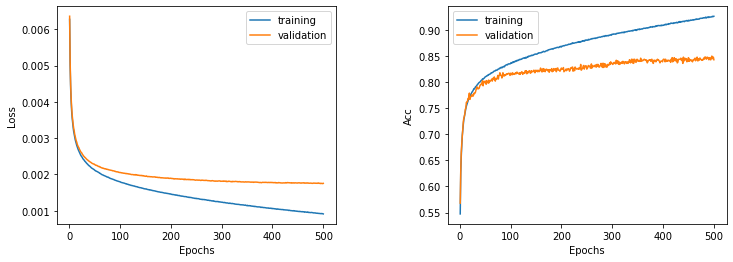

[0.831, 0.0017991326451301576]


In [16]:
optimizer = optim.Adam(model.parameters(), lr=5e-06)

epochs = 500

# modelsavedir = osp.join(lrdir, "16ch128ks")
# md_path = osp.join(modelsavedir, 'm30000_1600_expe_e1000.pth')

#training
tl, vl, ta, va = DL.train_model_ver3(flt, flv, model, criterion, optimizer, epochs, device)

#torch.save(model.state_dict(), md_path)
DL.learning_curv_ver2( 12, 4, 10, 10, tls = tl, vls = vl, tas = ta, vas = va)


val = DL.val_model(fltest, model, device, criterion, False)
print(val)

## mnist experiment dataset 68000train shuffle

In [4]:
outputdir = "../output/experiment/SLM_phase/mnist"
howdatadir = osp.join(outputdir, "id/midline_randomshuffle_68000train/")

datapath = '../dat/experiment/SLM/m_now/m_1_70000_slt0.6_N3_lsd_midline.dat'
labelpath='../dat/label/mnist_label.dat'

shfldir= "../output/experiment/SLM_phase"
shflidpath=osp.join(shfldir, "shuffle_first_68000.npy")
trainid = np.load(file=shflidpath)
shflidpath=osp.join(shfldir, "shuffle_68001_69000.npy")
valid = np.load(file=shflidpath)
shflidpath=osp.join(shfldir, "shuffle_69001_70000.npy")
testid = np.load(file=shflidpath)

In [5]:
mnist = mnc.My_numpy(1, datapath)
mnist.simread(70000, 1600)
print(mnist.data.shape)

mnist.data = mnist.data.reshape(70000, 1, 1600)
print(mnist.data.shape)

mlbl = mnc.My_numpy(4, labelpath)
mlbl.labelread(70000)
print(mlbl.data.shape)


myset = mtc.My_dataset2(mnist.data, mlbl.data)
myset.numpy2tensor_labelint()
traindata, trainlabel = myset.index_splitdata(trainid)
valdata, vallabel = myset.index_splitdata(valid)
testdata, testlabel = myset.index_splitdata(testid)

myset.set3data(traindata, val=valdata, test=testdata)
myset.set3label(trainlabel, val=vallabel, test=testlabel)

myset.datanormalize()
myset.tensor2dataset()

batch=256
mlt = DataLoader(myset.dataset_train, batch_size = batch, shuffle = True)
mlv = DataLoader(myset.dataset_val, batch_size = batch, shuffle = False)
mltest = DataLoader(myset.dataset_test, batch_size = batch, shuffle = False)

print(len(mlt), len(mlv), len(mltest))

(70000, 1600)
(70000, 1, 1600)
(70000,)
266 4 4


In [14]:
import importlib
importlib.reload(DL)

<module 'py_func.Deep_learning_torch_func' from '../py_func/Deep_learning_torch_func.py'>

### mnist 16ch128ks

##### 1000epoch 1e-05 none 学習率スケジューラは？ sota:0.001704 87.5%

In [15]:
channel = [1, 16]
kernel_size = [128]
pool_list = [2]
criterion = nn.NLLLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = my_model.cnn1d(channel, kernel_size, pool_list, 10, 0.5, 128).to(device)

/home/kawamoto/anaconda3/envs/mytorch373/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------epoch1------------------------------
train_loss0.0083 ,train_acc0.3049, val_loss0.0085 ,val_acc0.3000
epochtime:0.0399 minutes
----------------------------epoch2------------------------------
train_loss0.0074 ,train_acc0.4094, val_loss0.0076 ,val_acc0.4310
epochtime:0.0371 minutes
----------------------------epoch3------------------------------
train_loss0.0068 ,train_acc0.4644, val_loss0.0069 ,val_acc0.4820
epochtime:0.0372 minutes
----------------------------epoch4------------------------------
train_loss0.0063 ,train_acc0.5003, val_loss0.0065 ,val_acc0.5120
epochtime:0.0371 minutes
----------------------------epoch5------------------------------
train_loss0.0060 ,train_acc0.5230, val_loss0.0062 ,val_acc0.5410
epochtime:0.0363 minutes
----------------------------epoch6------------------------------
train_loss0.0057 ,train_acc0.5444, val_loss0.0059 ,val_acc0.5500
epochtime:0.0372 minutes
----------------------------epoch7------------------------------
train

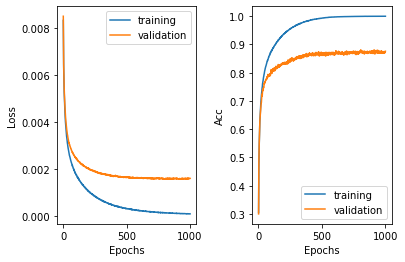

[0.871, 0.0017373356521129609]


In [16]:
optimizer = optim.Adam(model.parameters(), lr=1e-05)

epochs = 1000

lrdir=osp.join(howdatadir, "1e-05")
modelsavedir = osp.join(lrdir, "16ch128ks")
md_path = osp.join(modelsavedir, 'last.pth')

#training
tl, vl, ta, va = DL.train_model_ver3(mlt, mlv, model, criterion, optimizer, epochs, device, 
                                    mean_or_improve="improve", decision_num=10,
                                    modelsavedir=modelsavedir, saveepoch=400)

torch.save(model.state_dict(), md_path)
DL.learning_curv_ver2( 12, 4, 10, 10, tls = tl, vls = vl, tas = ta, vas = va)


val = DL.val_model(mltest, model, device, criterion, False)
print(val)

###### sota評価

In [17]:
lrdir=osp.join(howdatadir, "1e-05")
modelsavedir = osp.join(lrdir, "16ch128ks")

In [18]:
mdpath=osp.join(modelsavedir, "sota.pth")
model.load_state_dict(torch.load(mdpath))

<All keys matched successfully>

In [19]:
val = DL.val_model(mltest, model, device, criterion, False)
print(val)

[0.875, 0.001704302728176117]


##### 1e-05 gausian noise 学習率スケジューラは？ sota:0.001734 87.0%

In [20]:
channel = [1, 16]
kernel_size = [128]
pool_list = [2]
criterion = nn.NLLLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = my_model.cnn1d(channel, kernel_size, pool_list, 10, 0.5, 128).to(device)

----------------------------epoch1------------------------------
train_loss0.0080 ,train_acc0.3608, val_loss0.0082 ,val_acc0.3830
epochtime:0.0466 minutes
----------------------------epoch2------------------------------
train_loss0.0071 ,train_acc0.4479, val_loss0.0072 ,val_acc0.4560
epochtime:0.0444 minutes
----------------------------epoch3------------------------------
train_loss0.0065 ,train_acc0.4843, val_loss0.0067 ,val_acc0.4880
epochtime:0.0454 minutes
----------------------------epoch4------------------------------
train_loss0.0061 ,train_acc0.5179, val_loss0.0063 ,val_acc0.5290
epochtime:0.0469 minutes
----------------------------epoch5------------------------------
train_loss0.0058 ,train_acc0.5470, val_loss0.0060 ,val_acc0.5550
epochtime:0.0487 minutes
----------------------------epoch6------------------------------
train_loss0.0055 ,train_acc0.5697, val_loss0.0057 ,val_acc0.5770
epochtime:0.0465 minutes
----------------------------epoch7------------------------------
train

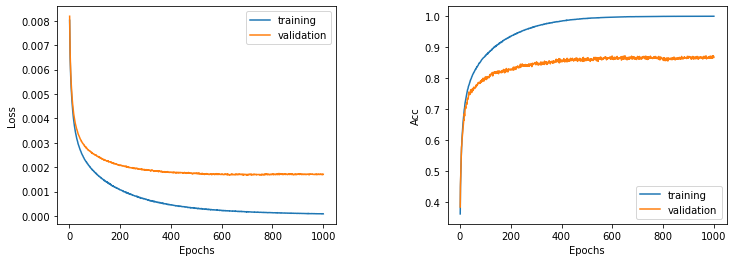

[0.873, 0.00177715864777565]


In [21]:
optimizer = optim.Adam(model.parameters(), lr=1e-05)

epochs = 1000

lrdir=osp.join(howdatadir, "gnoise/1e-05")
modelsavedir = osp.join(lrdir, "16ch128ks")
md_path = osp.join(modelsavedir, 'last.pth')

#training
tl, vl, ta, va = DL.train_model_ver3(mlt, mlv, model, criterion, optimizer, epochs, device, 
                                    mean_or_improve="improve", decision_num=10,
                                    gausnoise=True, stddev=0.007,
                                    modelsavedir=modelsavedir, saveepoch=400)

torch.save(model.state_dict(), md_path)
DL.learning_curv_ver2( 12, 4, 10, 10, tls = tl, vls = vl, tas = ta, vas = va)


val = DL.val_model(mltest, model, device, criterion, False)
print(val)

###### sota評価

In [22]:
lrdir=osp.join(howdatadir, "gnoise/1e-05")
modelsavedir = osp.join(lrdir, "16ch128ks")

In [23]:
mdpath=osp.join(modelsavedir, "sota.pth")
model.load_state_dict(torch.load(mdpath))

<All keys matched successfully>

In [24]:
val = DL.val_model(mltest, model, device, criterion, False)
print(val)

[0.87, 0.0017339346408843995]


##### 1e-05 mixup 学習率スケジューラは？ sota:0.001839 85.8%

In [25]:
channel = [1, 16]
kernel_size = [128]
pool_list = [2]
criterion = nn.NLLLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = my_model.cnn1d(channel, kernel_size, pool_list, 10, 0.5, 128).to(device)

---------------------------epoch1------------------------------
train_loss0.0085 ,train_acc0.3200, val_loss0.0087 ,val_acc0.3200
epochtime:0.0342 minutes
---------------------------epoch2------------------------------
train_loss0.0075 ,train_acc0.4342, val_loss0.0077 ,val_acc0.4330
epochtime:0.0347 minutes
---------------------------epoch3------------------------------
train_loss0.0068 ,train_acc0.4731, val_loss0.0070 ,val_acc0.4690
epochtime:0.0342 minutes
---------------------------epoch4------------------------------
train_loss0.0064 ,train_acc0.5121, val_loss0.0065 ,val_acc0.5000
epochtime:0.0346 minutes
---------------------------epoch5------------------------------
train_loss0.0060 ,train_acc0.5379, val_loss0.0062 ,val_acc0.5140
epochtime:0.0347 minutes
---------------------------epoch6------------------------------
train_loss0.0058 ,train_acc0.5588, val_loss0.0059 ,val_acc0.5410
epochtime:0.0333 minutes
---------------------------epoch7------------------------------
train_loss0.

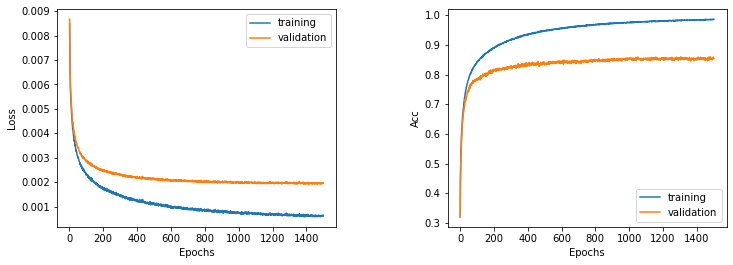

[0.866, 0.0018854640424251557]


In [26]:
optimizer = optim.Adam(model.parameters(), lr=1e-05)

epochs = 1500

lrdir=osp.join(howdatadir, "mixup/1e-05")
modelsavedir = osp.join(lrdir, "16ch128ks")
md_path = osp.join(modelsavedir, 'last.pth')

#training
tl, vl, ta, va = DL.train_model_mixup(mlt, mlv, model, criterion, optimizer, epochs, device, 
                                    mean_or_improve="improve", decision_num=10,
                                    mixalpha=1.2,
                                    modelsavedir=modelsavedir, saveepoch=400)

torch.save(model.state_dict(), md_path)
DL.learning_curv_ver2( 12, 4, 10, 10, tls = tl, vls = vl, tas = ta, vas = va)


val = DL.val_model(mltest, model, device, criterion, False)
print(val)

###### sota評価

In [27]:
lrdir=osp.join(howdatadir, "mixup/1e-05")
modelsavedir = osp.join(lrdir, "16ch128ks")
mdpath=osp.join(modelsavedir, "sota.pth")
model.load_state_dict(torch.load(mdpath))
val = DL.val_model(mltest, model, device, criterion, False)
print(val)

[0.858, 0.0018394562602043153]
